# Hive Data Warehouse on HDFS
Remember, we built a data warehouse, with a well defined structure using hive datasets and tables. We saved it on HDFS. Now we can access it with hive 'SQL' queries, MapReduce jobs but also with Spark (and its libraries: Spark SQL, Spark Streaming, Spark MLlib).

We can use this to process the BIG dataset, that we supposed is made up of all the listings and all the reviews ever written, studying on the whole dataset the patterns we discovered in the sandbox.

# Hive commands
First we need to start hadoop: `start-all.sh` and we always need to rember to stop it before shutting down: `stop-all.sh`.
We start the **hive** shell simply with: `hive`.

We show existing databases with `SHOW DATABASES;` and their tables with `SHOW TABLES;`. We create a new database with `CREATE DATABASE <database name>` and drop them with `DROP DATABASE <database name>`. We can select a specific database with `USE <database name>`.

An hive database contains *virtually* structured data. It is organized in 3 substructures:
 1. **Tables**: same concept as in relational databases (e.g. pandas DataFrames). They can be **internal** if hive handles their complete lifecycle, and they have a clear *relational* **schema**. There exist also external tables. However we will use internal tables, because we will save data already structured (via mongoDB) on hive databases, building a Data Warehouse, instead of stacking up directly the data on HDFS, forming a data lake. 
 
 We create a new table with `CREATE [EXTERNAL] TABLE [IF NOT EXISTS] [db_name.]table_name
(col_name data_type [COMMENT 'col_comment'],, ...)
[COMMENT 'table_comment']
[ROW FORMAT row_format]
[FIELDS TERMINATED BY char]
[STORED AS file_format];`
 2. **Partitions**: tables are organized in partitions, in order to allow faster queries on slices of data. Each table can have one or more partition keys.
 We partitioned our dataset on the basis of the city: we added `PARTITIONED BY (partition_name STRING);` to the table creation command and ` PARTITION (partition=’2009′)` in the loading command.
 3. **Buckets**: partitions can be organized into Buckets by using an hash function computed on a column in the original table. Each bucket is just a file in the partition directory.

# Hive in our project
I created an **airbnb** database: `CREATE DATABASE airbnb;`.

Then I created **listings**, **reviews**, and **calendar** tables.

## Reviews
`CREATE TABLE IF NOT EXIST airbnb.reviews 
(listing_id INT, id INT, date DATE, reviewer_id INT, reviewer_name CHAR, comments VARCHAR) 
ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' PARTITIONED BY (city STRING);`, ecc...

Then I loaded the corresponding files from HDFS to the new tables.
`LOAD DATA INPATH '/AIRBNB_PROJECT/Florence/reviews.csv' INTO TABLE reviews PARTITION(city=Florence);`

Hive allows much simpler queries, joins, group by, while maintaing the ability of processing big datasets (hive SQL queries just automatically write and execute a Map Reduce Job): e.g. `SELECT date,count(*) FROM reviews GROUP BY date;` does the exaclty same thing of the Map Reduce Job that I wrote, but without the complications of directly writing the mapper and the reducer. 

# Hadoop Map Reduce Job execution
streaming command:
`hadoop jar /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.10.0.jar -file ./mapper.py -mapper mapper.py -file ./reducer.py -reducer reducer.py -input /AIRBNB_PROJECT/MapReduceJob/reviews_dates.csv -output /AIRBNB_PROJECT/MapReduceJob/reviews_grouped_by_date`

NOTE: If we use hive to process small datasets (as can be the reviews file from Florence) it is much slower than standard python (pandas), because first it has to translates the query into a MapReduce Job. So the advantage of using hive manifest only when dealing with large datasets, that can be processed in parallel, using hadoop **distributed** network.

## Calendar
`CREATE TABLE IF NOT EXISTS airbnb.calendar 
(listing_id INT, date_ DATE, available STRING, price INT, min_nights INT, max_nights INT) 
ROW FORMAT DELIMITED FIELDS TERMINATED BY ',';`


`LOAD DATA INPATH '/AIRBNB_PROJECT/Florence/calendar_2022-06-11.csv' INTO TABLE calendar PARTITION(city=Florence);`

# Spark in our project
We can access directly the hive database, and its tables, with pyspark.

In [ ]:
# initialize pyspark and make it callable as a regular python library
import findspark
findspark.init()

# import the required modules
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row

# specify the app name
appName = "hive_pyspark"

# I enabled 2 cores for the virtual machine
# 2 is the number of enabled RDD or Dataframe partitions
master = "local[2]" 

In [ ]:
# create a Spark session 
spark = SparkSession.builder\
        .master(master).appName(appName)\
        .enableHiveSupport().getOrCreate()

22/09/18 20:53:56 WARN Utils: Your hostname, dsbdaStation resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
22/09/18 20:53:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/09/18 20:53:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# verify the databases in hive
db = spark.sql("show databases")
db.show()

22/09/18 20:54:12 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
22/09/18 20:54:12 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist


+---------+
|namespace|
+---------+
|   airbnb|
|  default|
|     mydb|
+---------+



In [ ]:
# verify the tables
spark.sql("use airbnb")
spark.sql("show tables").show()

22/09/18 20:54:21 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|   airbnb| calendar|      false|
|   airbnb| listings|      false|
|   airbnb|  reviews|      false|
+---------+---------+-----------+



#### Reviews table
Here I will import also the review table, I am doing it with Spark, because it can automatically infer the schema, and this file has 96 attributes.

The strategy is: 
 - automatically infer the schema from a small slice of data
 - create a hive table with that schema
 - import all the other data from the mongoDB repository, in accordance to this schema
 
#### HDFS file system path

Unlike other filesystems, to access files from HDFS you need to provide the Hadoop name node path, you can find this on Hadoop `core-site.xml` file under Hadoop configuration folder. On this file look for `fs.defaultFS` property and pick the value from this property. for example, you will have the value in the below format `hdfs://nn1home:8020`. replace nn1home and port from the value in `fs.defaultFS` property.

In [ ]:
# Creating dataframe from the cv file and infering the schema
#listings = spark.read.load("hdfs://localhost:54310/AIRBNB_PROJECT/Florence/listings.csv", format="csv", sep=",", inferSchema="true", header="true")
#calendar = spark.read.load("hdfs://localhost:54310/AIRBNB_PROJECT/Florence/calendar_cleaned/calendar.csv", format="csv", sep=",", inferSchema="true", header="true")

from pyspark.sql.types import FloatType, StructField, StructType, StringType, DateType, IntegerType
# specify the schema (we are streaming the csv file, not loading it,
#so we can't go over it all to infer the schema)
reviewsSchema = StructType([
    StructField("listing_id",IntegerType(), True),
    StructField("id",IntegerType(), True),
    StructField("date",DateType(), True),
    StructField("reviewer_id",IntegerType(), True),
    StructField("reviewer_name",StringType(), True),
    StructField("comment",StringType(), True)
])
reviews = spark.read.schema(reviewsSchema).load("hdfs://localhost:54310/AIRBNB_PROJECT/Florence/reviews.csv", format="csv",\
                          sep=",", header="true").drop()

In [ ]:
#listings.first()
#listings.printSchema()
#listings.show()
#calendar.show()

In [ ]:
# save listings into a hive table
#listings.write.mode('overwrite').saveAsTable('airbnb.listings') # note: in our architecture we should use mode('append')
#calendar.write.mode('overwrite').saveAsTable('airbnb.calendar')
#reviews.write.mode('overwrite').saveAsTable('airbnb.reviews')
tables = spark.sql("show tables")
tables.show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|   airbnb| calendar|      false|
|   airbnb| listings|      false|
|   airbnb|  reviews|      false|
+---------+---------+-----------+



In [ ]:
# import the hive tables as Spark Dataframes
calendar = spark.sql('SELECT * FROM calendar')
calendar.show(1)
reviews = spark.sql('SELECT * FROM reviews')
reviews.show(1)
listings = spark.sql('SELECT * FROM listings')
#listings.show(1)

+---+----------+----------+---------+-----+--------------+--------------+--------------+
|_c0|listing_id|      date|available|price|adjusted_price|minimum_nights|maximum_nights|
+---+----------+----------+---------+-----+--------------+--------------+--------------+
|  0|    422655|2022-03-20|        f| 67.0|          67.0|           2.0|        1125.0|
+---+----------+----------+---------+-----+--------------+--------------+--------------+
only showing top 1 row



+----------+---------+----------+-----------+-------------+--------------------+
|listing_id|       id|      date|reviewer_id|reviewer_name|             comment|
+----------+---------+----------+-----------+-------------+--------------------+
|  11312673|204841170|2017-10-20|    1323222|      Natalie|My fiancé and I s...|
+----------+---------+----------+-----------+-------------+--------------------+
only showing top 1 row



In [ ]:
calendar.dtypes

[('_c0', 'int'),
 ('listing_id', 'bigint'),
 ('date', 'string'),
 ('available', 'string'),
 ('price', 'double'),
 ('adjusted_price', 'double'),
 ('minimum_nights', 'double'),
 ('maximum_nights', 'double')]

In [ ]:
#calendar.describe().show()
reviews.count()

618675

# Data Visualization and Hypothesis validation
We perform all operations on the big dataset with spark, then we export the result dataset to pandas and we plot the results with matplotlib.

We started with the same thing as in the Sandbox: counting the reviews per each day. Then we computed the moving average and the seasonality.

Then we exported the results to pandas, for visualization.

In [ ]:
stays_per_day = spark.sql('SELECT date,count(*) FROM reviews GROUP BY date ORDER BY date;')
stays_per_day.dtypes

[('date', 'date'), ('count(1)', 'bigint')]

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as func
days = lambda i: i * 86400

w = (Window()
   .orderBy(func.col("date").cast("timestamp").cast("long"))
   .rangeBetween(-days(365), 0))
w2 = (Window()
   .orderBy(func.col("date").cast("timestamp").cast("long"))
   .rangeBetween(-days(30), 0))

stays_per_day = stays_per_day.select(func.col("*"), func.mean("count(1)").over(w).alias("rolling_avg_1year"))
stays_per_day = stays_per_day.select(func.col("*"), func.mean("count(1)").over(w2).alias("rolling_avg_1month"))
stays_per_day.show(100)


22/09/18 22:45:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 22:45:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 22:45:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 22:45:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 22:45:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 22:45:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 2

+----------+--------+------------------+------------------+
|      date|count(1)| rolling_avg_1year|rolling_avg_1month|
+----------+--------+------------------+------------------+
|      null|   79811|           79811.0|           79811.0|
|2010-06-17|       1|               1.0|               1.0|
|2010-06-23|       1|               1.0|               1.0|
|2010-07-16|       1|               1.0|               1.0|
|2010-07-19|       1|               1.0|               1.0|
|2010-08-02|       1|               1.0|               1.0|
|2010-08-13|       1|               1.0|               1.0|
|2010-08-19|       1|               1.0|               1.0|
|2010-09-05|       1|               1.0|               1.0|
|2010-09-07|       1|               1.0|               1.0|
|2010-09-09|       1|               1.0|               1.0|
|2010-09-11|       1|               1.0|               1.0|
|2010-09-13|       2|1.0833333333333333|1.1666666666666667|
|2010-09-14|       1|1.0769230769230769|

<AxesSubplot:xlabel='date'>

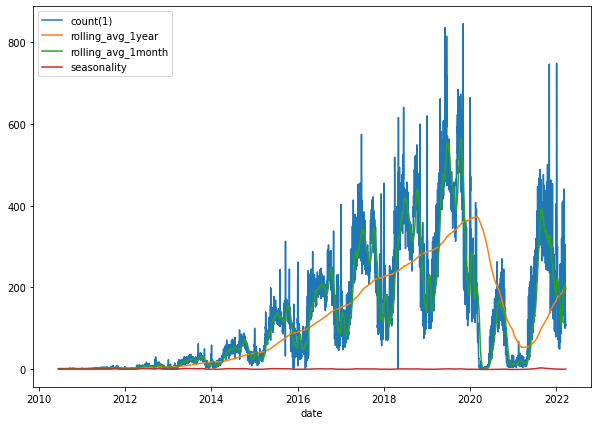

In [ ]:
pd_stays_per_day = stays_per_day.toPandas()
pd_stays_per_day.set_index('date').iloc[1:].plot(figsize=(10,7))

In [ ]:
stays_per_day = stays_per_day.withColumn('seasonality',(stays_per_day['rolling_avg_1month']-\
                stays_per_day['rolling_avg_1year'])/stays_per_day['rolling_avg_1year'])

<AxesSubplot:xlabel='date'>

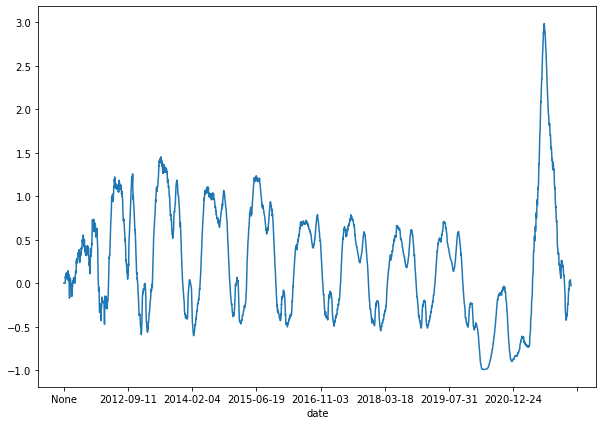

In [ ]:
pd_seasonality = stays_per_day.toPandas()
pd_seasonality.set_index('date')['seasonality'].plot(figsize = (10,7))

In [ ]:
stays_per_day.withColumnRenamed('count(1)', 'counts').write.mode('overwrite').saveAsTable('airbnb.stays_per_day')

22/09/18 23:18:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 23:18:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 23:18:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 23:18:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 23:18:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 23:18:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/09/18 2

In [ ]:
#stays_per_day = spark.sql('SELECT * FROM stays_per_day;')

In [ ]:
from pyspark.sql.functions import year, dayofyear
stays_per_day = stays_per_day.withColumn('year', year(stays_per_day.date)).withColumn('day_of_year', dayofyear(stays_per_day.date))
pivoted_df = stays_per_day.groupBy('day_of_year').pivot('year').sum('count(1)')

In [ ]:
pivoted_df.show(10)

+-----------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|day_of_year|null|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|2022|
+-----------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|        148|null|null|   1|   9|  18|  39| 117| 214| 453| 419| 448|   6|  79|null|
|        243|null|null|null|   4|  20|  54| 125| 156| 251| 331| 313| 201| 265|null|
|         31|null|null|null|null|   2|   6|  19|  70|  69|  70| 126| 150|  26| 144|
|        251|null|null|   6|   4|  39|  73| 136| 189| 334| 371| 513| 158| 328|null|
|         85|null|null|   1|   1|   1|  17|  36| 143| 294| 247| 239|   4|  16|null|
|        137|null|null|   1|   3|  30|  44| 156| 228| 252| 299| 480|   2|  67|null|
|         65|null|null|null|null|   3|   9|  20|  54| 105| 110| 191|  65|  24| 441|
|         53|null|null|   1|null|   7|  13|  35|  68|  79| 115| 176| 233|  20| 132|
|        255|null|null|   3|   8|null|  76| 139| 291| 310| 378| 481| 132| 47

In [ ]:
from pyspark.mllib.stat import Statistics
import pandas as pd

# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

corrs = compute_correlation_matrix(pivoted_df, method='spearman')
corrs_styled = corrs.style.background_gradient(cmap='coolwarm').format(precision=2)
corrs_styled
#pivoted_df.stat.corr()

,day_of_year,null,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
day_of_year,1.00,-0.03,-0.19,-0.10,-0.03,0.37,0.47,0.42,0.35,0.20,0.23,0.20,-0.22,0.76,0.49
null,-0.03,1.00,0.79,0.08,0.04,-0.03,0.04,-0.00,0.02,0.02,0.01,0.03,0.01,-0.05,0.62
2010,-0.19,0.79,1.00,0.07,-0.02,-0.18,-0.13,-0.15,-0.12,-0.10,-0.13,-0.10,-0.04,-0.22,0.39
2011,-0.10,0.08,0.07,1.00,0.06,-0.16,-0.14,-0.16,-0.16,-0.11,-0.14,-0.16,0.15,-0.09,-0.16
2012,-0.03,0.04,-0.02,0.06,1.00,0.25,0.18,0.17,0.21,0.17,0.21,0.22,0.18,0.11,-0.01
2013,0.37,-0.03,-0.18,-0.16,0.25,1.00,0.76,0.73,0.71,0.69,0.76,0.73,0.04,0.53,0.38
2014,0.47,0.04,-0.13,-0.14,0.18,0.76,1.00,0.82,0.76,0.72,0.78,0.82,0.05,0.62,0.51
2015,0.42,-0.00,-0.15,-0.16,0.17,0.73,0.82,1.00,0.80,0.74,0.77,0.79,0.00,0.61,0.47
2016,0.35,0.02,-0.12,-0.16,0.21,0.71,0.76,0.80,1.00,0.73,0.74,0.75,0.01,0.63,0.46
2017,0.20,0.02,-0.10,-0.11,0.17,0.69,0.72,0.74,0.73,1.00,0.84,0.82,-0.05,0.40,0.43


In [ ]:
from pyspark.mllib.stat import Statistics

def compute_correlation_matrix(df, method='pearson'):
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat, columns=df.columns, index=df.columns)
    return corr_mat_df

corrs = compute_correlation_matrix(pivoted_df, method='spearman').style.background_gradient(cmap='coolwarm').format(precision=2)

In [ ]:
spark.stop()